# Action recognition by image classification

Get a understanding of the how well image based action recognition performs.

In [3]:
data_dir = 'data/haa500'
train_dir = os.path.join(data_dir, 'train-img')
val_dir = os.path.join(data_dir, 'val-img')
train_txt = os.path.join(data_dir, 'train-img.txt')
val_txt = os.path.join(data_dir, 'val-img.txt')

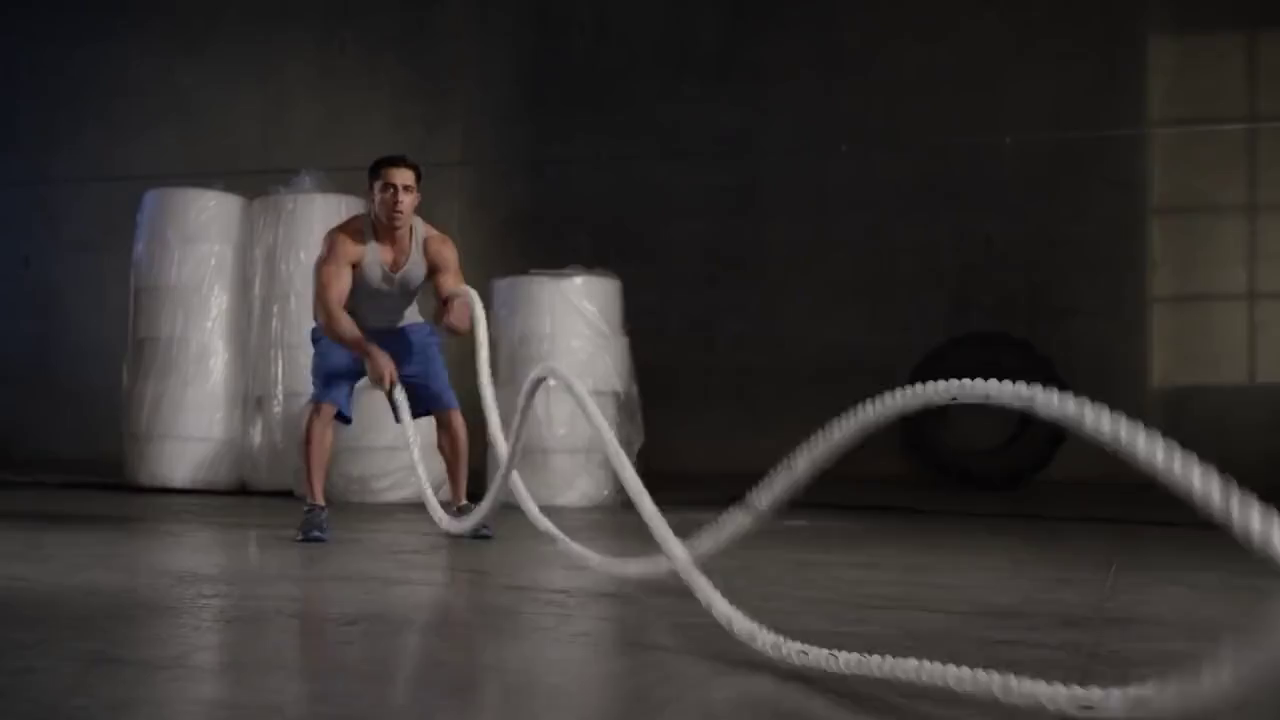

In [4]:
from PIL import Image
Image.open(os.path.join(train_dir, 'battle-rope_wave_000_1.png'))

# PyTorch

In [5]:
import matplotlib.pyplot as plt
import time
import os
import copy

import numpy as np

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torchvision import datasets, models
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore")

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
data_transforms = {
    'train': T.Compose([
        T.RandomResizedCrop(224),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': T.Compose([
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/haa500'

class Mydataset(Dataset):
    def __init__(self, data_dir, train=True, transform=False):
        self.data_dir = data_dir
        self.transform = transform
        if train:
            self.data_transforms = data_transforms['train']
            label_txt = os.path.join(data_dir, 'train-img.txt') 
        else:
            self.data_transforms = data_transforms['val']
            label_txt = os.path.join(data_dir, 'val-img.txt')
        annos = None
        with open(label_txt, 'r') as f:
            annos = f.readlines()
        annos = [label.strip() for label in annos]
        self.imgs, self.labels = zip(*[[label.split(' ')[0], label.split(' ')[1]] for label in annos])
        self.labels = [int(label) for label in self.labels]

        with open(os.path.join(data_dir, 'class.txt'), 'r') as f:
            self.classes = f.readlines()
        self.classes = [label.strip() for label in self.classes]
        self.classes = dict(enumerate([c.split()[0] for c in self.classes]))
        
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.imgs[idx])
        img = T.ToPILImage()(read_image(img_path))
        if self.transform:
            img = self.data_transforms(img)
        label = self.labels[idx]
        classname = self.classes[int(label)]
        return img, label, classname


In [12]:
train_set = Mydataset(data_dir, train=True, transform=True)
val_set = Mydataset(data_dir, train=False, transform=True)
train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4, shuffle=True)
class_names = train_set.classes
dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_set), 'val': len(val_set)}

torch.Size([4, 3, 224, 224]) tensor([12,  9, 13, 12]) ('side_lunge', 'gym_run', 'situp', 'side_lunge')


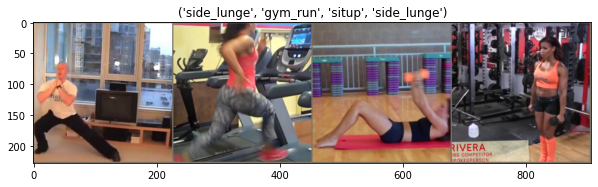

In [13]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    plt.figure(figsize=(10,5))
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, labels, classes = next(iter(dataloaders['val']))
print(inputs.shape, labels, classes)
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=classes)

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels, _ in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [15]:
def visualize_model(model, num_batch=2):
    was_training = model.training
    model.eval()
    num_row = num_batch*2
    fig, axes = plt.subplots(num_row, 2, figsize=(10, 10), dpi=200)
    with torch.no_grad():
        for i in range(num_row):
            inputs, labels, classnames = next(iter(dataloaders['val']))
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            preds = preds.to('cpu').data.numpy()
            labels = labels.to('cpu').data.numpy()
            inputs = inputs.to('cpu')
            correct = np.squeeze(preds == labels)
            color = ['green' if correct[j] else 'red' for j in range(num_batch)]
            for j in range(2):
                ax = axes[i, j]
                ax.axis('off')
                ax.set_title(f'pred={class_names[preds[j]]}, true={class_names[labels[j]]}', color=color[j])
                inp = inputs[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)
                ax.imshow(inp)

        model.train(mode=was_training)

In [16]:
model_ft = models.resnet18(pretrained=True)
# for param in model_ft.parameters():
#     param.requires_grad = False
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft, history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

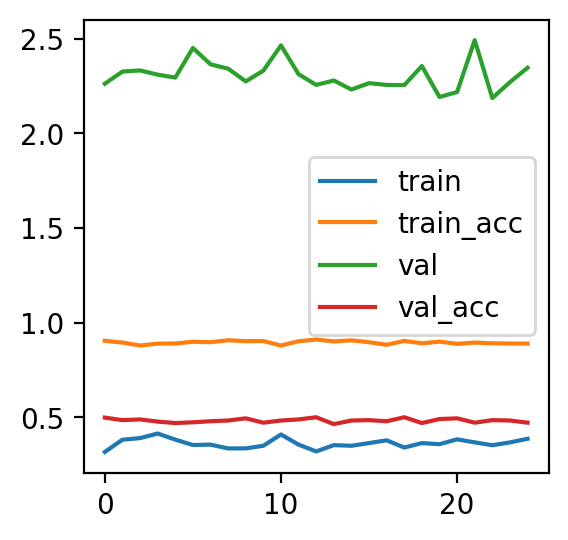

In [130]:
plt.figure(dpi=200, figsize=(3,3))
plt.plot(history['train_loss'], label='train_loss')
plt.plot([d.to('cpu').data for d in history['train_acc']], label='train_acc')
plt.plot(history['val_loss'], label='val_loss')
plt.plot([d.to('cpu').data for d in history['val_acc']], label='val_acc')
plt.legend()
plt.show()


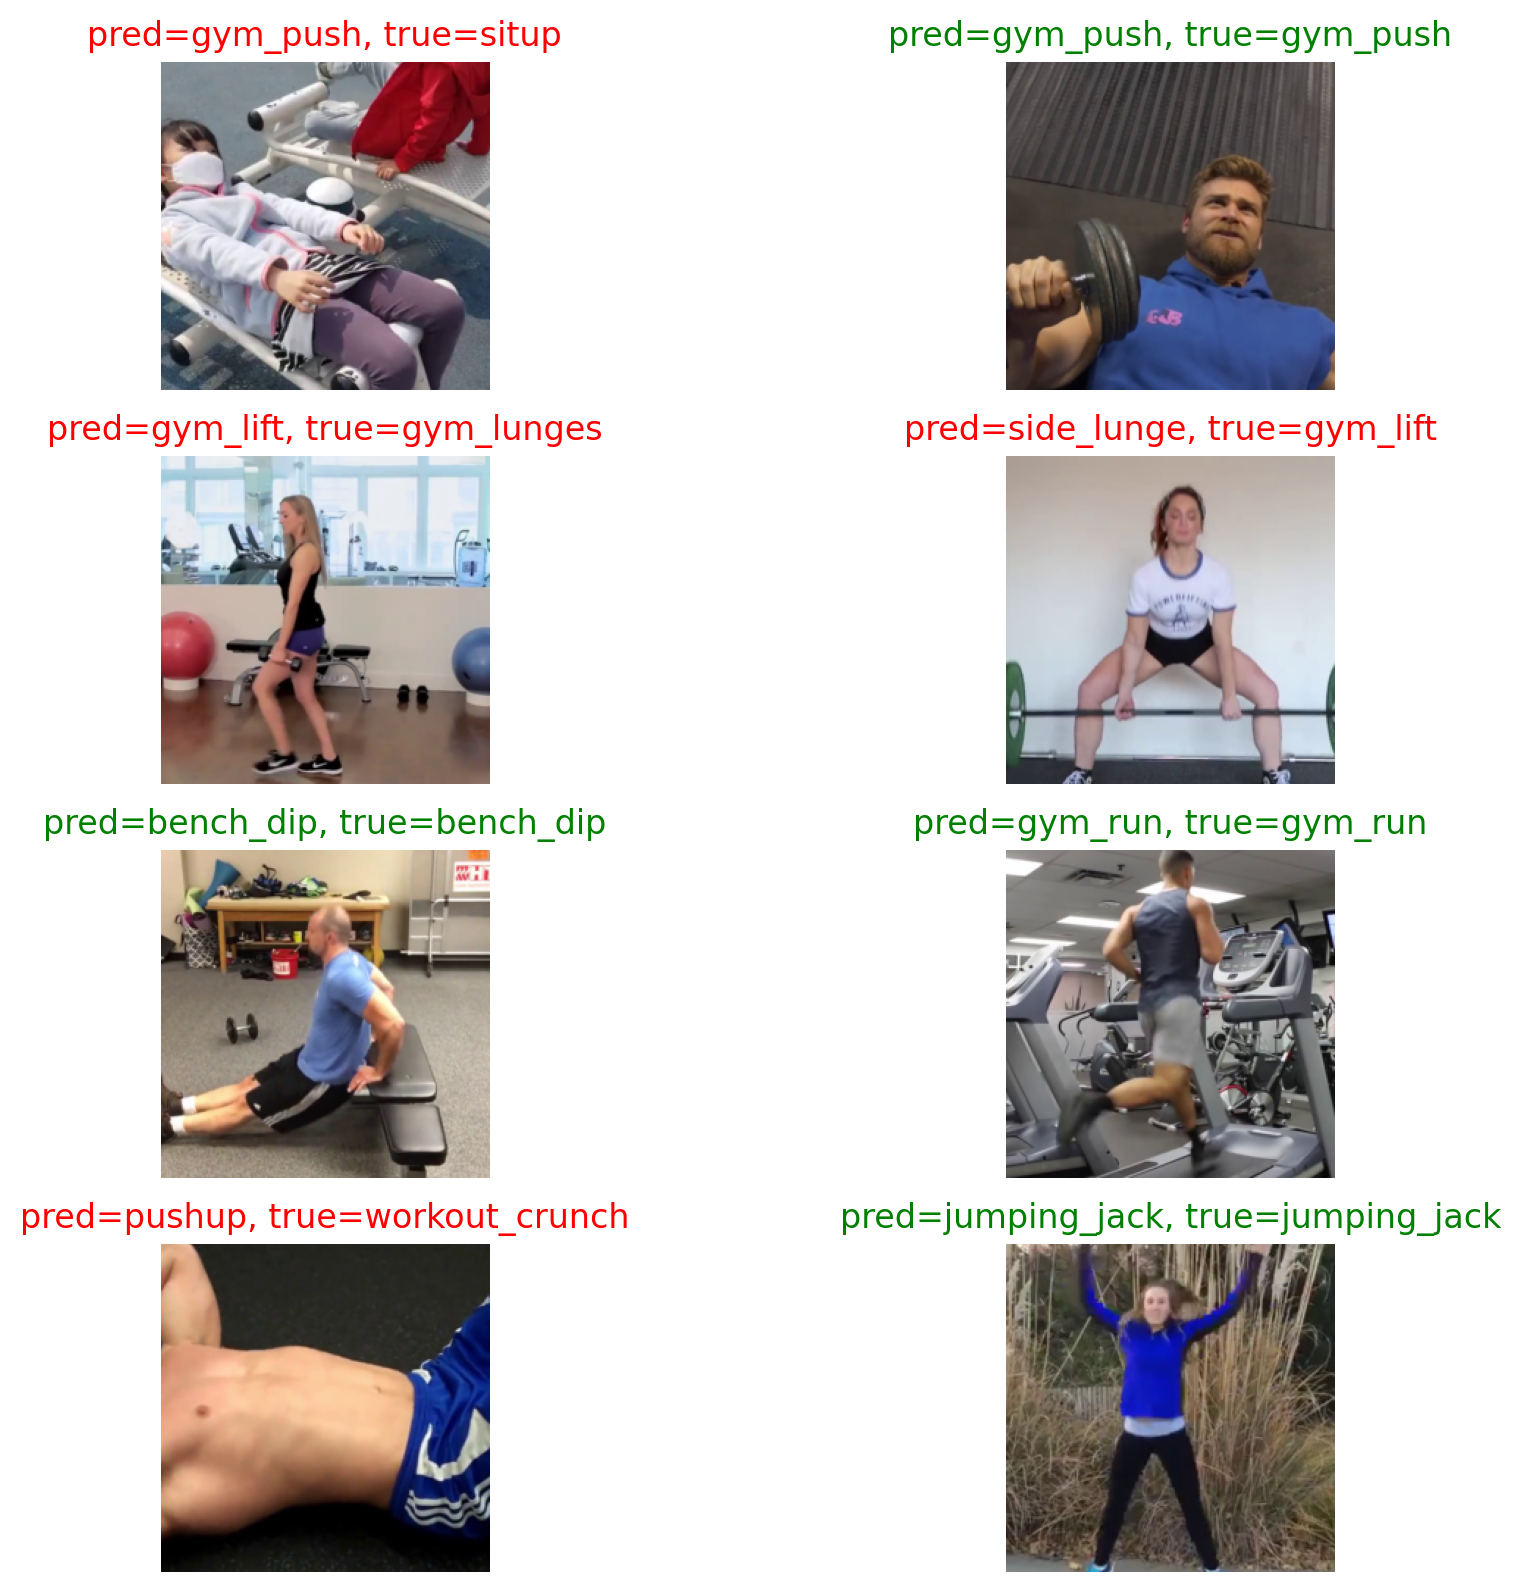

In [116]:
visualize_model(model_ft)